# Groupe E - Projet de Deep Learning 

Luis Dierick, Tom Marchal

## Mise en place

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms.v2 as T2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler

import intel_extension_for_pytorch as ipex


device = 'xpu' if torch.xpu.is_available() else 'cpu' # Utilise la carte graphique, si GPU intel est disponible


NB_CLASSES = 8
CLASSES = ['battery', 'cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textile']
NB_EPOCHS = 100
BATCH_SIZE = 32
DTYPE = torch.float32
LR = 0.001
L1_REG = 0.01
TRAIN_DATA = "./waste-classification-challenge/train/train/"
TEST_DATA = "./waste-classification-challenge/test/test/"


/home/dierickl/.local/lib/python3.10/site-packages/intel_extension_for_pytorch/llm/__init__.py:9: UserWarning: failed to use huggingface generation fuctions due to: No module named 'transformers'.
  warnings.warn(f"failed to use huggingface generation fuctions due to: {e}.")




Pour réaliser ce projet, nous avons besoin de plusieurs librairies python. A savoir principalement : 
- PyTorch et Scikit Learn pour pouvoir créer notre CNN et utiliser des fonctions utiles en machine learning
- Numpy pour manipuler et calculer certaines caractéristiques sur des tableaux
- Matplotlib pour visualiser nos résultats

Pour information, le modèle a été entrainé sur un GPU Intel d'où la présence du module `intel_extension_for_pytorch` qui permet d'utiliser l'accelération GPU et optimiser les calculs sur celle-ci.

On definit également certaines variables qui resteront constantes durant l'entrainement.






## Données
Au niveau des données, nous avons reçu initialement $\approx$ 8000 images de déchets. Le set d'entrainement contient $\approx$ 5500 images labbelées en 8 catégories (battery, cardboard, glass, metal, organic, paper, plastic, textile). Les $\approx$ 2500 images restantes ne sont pas labbelées et servent à soumettre nos predictions pour la competition Kaggle.




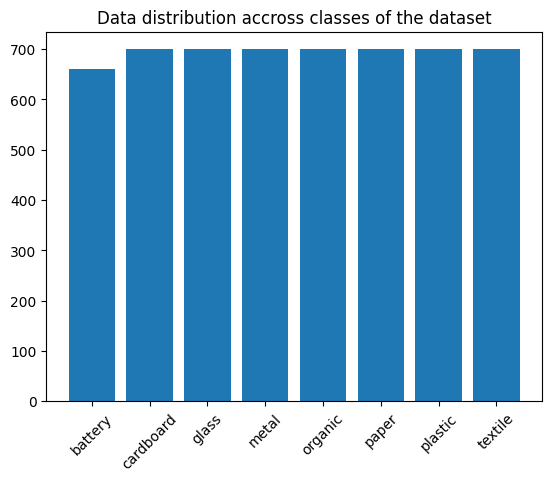

In [2]:
train_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.RandomHorizontalFlip(),
        T2.RandomVerticalFlip(),
        T2.RandomRotation(degrees=30),
        T2.RandomAffine(degrees=0),
        T2.RandomChannelPermutation(),
        T2.RandomResizedCrop(224, scale=(0.6, 1), antialias=True),
        T2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)),
        T2.GaussianBlur(kernel_size=(3, 9)),
    ]
).to(device)

test_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.Resize(224, antialias=True),
        T2.CenterCrop(224),
    ]
).to(device)

dataset = ImageFolder(root=TRAIN_DATA)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Data distribution
x = np.arange(NB_CLASSES)
y = []
for i in range(NB_CLASSES):
    y.append(dataset.targets.count(i))

plt.title("Data distribution accross classes of the dataset")
plt.bar(x, y)
plt.xticks(x, CLASSES, rotation=45)
plt.show()

    
    


### Préprocessing
Pour entrainer le modèle, on ne travaille pas directement sur l'image mais sur une représentation de celle sous forme d'une matrice (Tensor). Les variables `train_transform` et `test_transform` permettent de réaliser ces transformations en plus de les normaliser.

### Expension du dataset


## Campagne de selection d'un modèle

### Procédure globale

Le workflow est le suivant : on sépare les données d'entrainements en un set d'entrainement et un set de validation. Ce set de validation permet d'evaluer les performances de nos modèles afin de pouvoir trouver le plus approprié. Une fois le modèle bien définit, on le réentrainera une nouvelle fois mais sur l'intégralité des données cette fois ci.

Afin de trouver une architecture adaptée à notre objectif, nous nous sommes inspiré de modèles de classifcation d'images existant. Dans notre cas, on s'est innspiré de VGG11. En partant de sa structure de base, nous avons essayé de l'adapter au mieux afin d'obtenir les meilleures performances possibles.



### Techniques de régularisation

- Régularisation L1 / L2 (weight decay)
- Dropout

### Résultats

In [3]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),

        )
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(256),
            # nn.Dropout(0.3),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.BatchNorm1d(128),
            # nn.Dropout(0.3),
            # nn.Linear(128, 64),
            # nn.ReLU(),
            # nn.BatchNorm1d(64),
            # nn.Dropout(0.3),

            # nn.Linear(128, 64),
            # nn.ReLU(),
            # nn.BatchNorm1d(64),
            # nn.Dropout(0.3),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            # nn.BatchNorm1d(32),
            # nn.Dropout(0.3),
            # nn.Linear(32, 16),
            # nn.ReLU(),
            # nn.BatchNorm1d(16),
            # nn.Dropout(0.3),
            # nn.Linear(4096, 2048),
            # nn.ReLU(),
            # nn.BatchNorm1d(2048),
            # nn.Linear(2048, 1024),
            # nn.ReLU(),
            # nn.BatchNorm1d(1024),
            # nn.Linear(1024, 512),
            # nn.ReLU(),
            # nn.BatchNorm1d(512),
            # nn.Dropout(0.3),
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(256),
            # nn.Dropout(0.3),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.BatchNorm1d(128),
            # nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimentions in one
        x = torch.flatten(x, 1)
        
        # Classifiy the image
        x = self.classifier(x)
        return x
    

In [4]:
model = CustomCNN(num_classes=NB_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.01)
model = model.to(device)
criterion = criterion.to(device)
if device == 'xpu':
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=DTYPE)

In [5]:
def train_epoch(model, train_loader):
    ########## Training ##########
    model.train()

    train_n_corrects = 0
    train_n_total = 0
    train_losses = []

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = criterion(output, target)
            _, predicted = torch.max(output, 1)

            # L1_term = torch.tensor(0., requires_grad=True)
            # for name, weights in model.named_parameters():
            #     if 'bias' not in name:
            #         weights_sum = torch.sum(torch.abs(weights))
            #     L1_term = L1_term + weights_sum

            # L1_term = L1_term / nweights
            # loss = loss + L1_REG * L1_term


        train_n_corrects += (predicted == target).sum().item()
        train_n_total += target.numel()
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_epoch_acc = train_n_corrects / train_n_total
    train_epoch_loss = np.mean(train_losses).__float__()

    ########## Print results ##########
    print(f"Train accuracy: {train_epoch_acc}")
    print(f"Train loss: {train_epoch_loss}")
    print("--------------------")

    return model, train_epoch_acc, train_epoch_loss

In [6]:
def test_model(model, test_loader, val_values, val_predictions):
    ########## Testing ##########
        model.eval()
        test_n_corrects = 0
        test_n_total = 0
        test_losses = []
        
        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)
                _, predicted = torch.max(output, 1)

                val_values.append(target)
                val_predictions.append(predicted)
                test_n_corrects += (predicted == target).sum().item()
                test_n_total += target.numel()
                test_losses.append(loss.item())

        test_epoch_acc = test_n_corrects / test_n_total
        test_epoch_loss = np.mean(test_losses).__float__()

        #### Print results ####
        print(f"Test accuracy: {test_n_corrects / test_n_total}")
        print(f"Test loss: {np.mean(test_losses)}")
        print("--------------------")

        return test_epoch_acc, test_epoch_loss, val_values, val_predictions

In [ ]:
def train_model(model, full_dataset):

    if full_dataset:
        dataset.transform = train_transform
        sampler = RandomSampler(dataset)
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    elif not full_dataset:
        train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
        train_dataset.dataset.transform = train_transform
        test_dataset.dataset.transform = test_transform
        train_sampler = RandomSampler(train_dataset)
        test_sampler = RandomSampler(test_dataset)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)


    train_graph_acc = []
    train_graph_loss = []
    test_graph_acc = []
    test_graph_loss = []

    val_values = []
    val_predictions = []


    # nweights = 0
    # for name,weights in model.named_parameters():
    #     if 'bias' not in name:
    #         nweights = nweights + weights.numel()
        

    for epoch in range(NB_EPOCHS):
        print(f"Epoch {epoch}")
        model, train_epoch_acc, train_epoch_loss = train_epoch(model, train_loader)

        if not full_dataset:
            test_epoch_acc, test_epoch_loss, val_values, val_predictions = test_model(model, test_loader, val_values, val_predictions)
            
            train_graph_acc.append(train_epoch_acc)
            train_graph_loss.append(train_epoch_loss)
            test_graph_acc.append(test_epoch_acc)
            test_graph_loss.append(test_epoch_loss)

    ########## Visualise results ##########
    x = np.arange(1, NB_EPOCHS + 1)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of epochs')
    ax1.set_ylabel('Accuracy')
    ax1.plot(x, train_graph_acc, label='Train Accuracy', color='tab:blue')
    ax1.plot(x, test_graph_acc, label='Test Accuracy', color='tab:cyan')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss')
    ax2.plot(x, train_graph_loss, label='Train Loss', color='tab:green')
    ax2.plot(x, test_graph_loss, label='Test Loss', color='tab:olive')
    ax2.tick_params(axis='y')
    fig.legend()
    plt.show()

    plt.figure()
    cm = confusion_matrix(torch.cat(val_values).cpu(), torch.cat(val_predictions).cpu())
    cm_display = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
    cm_display.plot(xticks_rotation='vertical')
    plt.show()
    
    return model

In [ ]:
trained_model = train_model(model, full_dataset=False)

########## Save the model ##########
torch.save(trained_model.state_dict(), 'model.pth')


Epoch 0


100%|██████████| 139/139 [00:12<00:00, 10.70it/s]


Train accuracy: 0.4199640287769784
Train loss: 1.865969853435489
--------------------


100%|██████████| 35/35 [00:03<00:00, 10.85it/s]


Test accuracy: 0.5161870503597122
Test loss: 1.7651354142597744
--------------------
Epoch 1


 33%|███▎      | 46/139 [00:04<00:08, 11.27it/s]

## Submission Kaggle
Cette partie est consacrée à reprendre le modèle entrainé et à prédire une classe sur de nouvelles images non connues et non labellées. Ces prédictions sont exportées dans un fichier .csv avec les identifiants de chaque image afin de pouvoir être évaluées dans le cadre d'une compétiton Kaggle.


In [ ]:
class WasteSubmissionDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.image_list = os.listdir(main_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.image_list[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        img_id = os.path.splitext(os.path.basename(img_loc))[0]
        return tensor_image, img_id

test_dataset = WasteSubmissionDataset(main_dir=TEST_DATA, transform=test_transform)
submission_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



Ici, on redéfinit une classe personnalisée pour transformer nos images en Tensors. Les transformations appliquées sont identiques à celles du set de validation.

In [ ]:
def generate_submission(model, submission_loader):
    model.eval()

    images_id = []
    predictions = []
    
    with torch.no_grad():
        for batch_idx, (img, tuple_img_id) in enumerate(submission_loader):
            img = img.to(device)
            output = model(img)
            prob = torch.nn.functional.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            for i, img_id  in enumerate(tuple_img_id):
                images_id.append(img_id)
                predictions.append(CLASSES[predicted[i]])
    
    
    df = pd.DataFrame({'ID': images_id, 'Label': predictions})
    df.to_csv('submission.csv', index=False)
    
    print(df.head())

generate_submission(trained_model, submission_loader)